Importation de Packages:

In [1]:

import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
import tensorflow as tf
from tensorflow.python.framework import ops

import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

In [2]:
from google.colab import drive
drive.mount('/content/gdrive/')

MessageError: ignored

This dataset teach our computers to decipher sign language. The datset is about taking pictures in front of a white wall. It helps to build an algorithm that would facilitate communications from a speech-impaired person to someone who doesn't understand sign language.

Training set: 1080 pictures (64 by 64 pixels) of signs representing numbers from 0 to 5 (180 pictures per number).
Test set: 120 pictures (64 by 64 pixels) of signs representing numbers from 0 to 5 (20 pictures per number).
Note that this is a subset of the SIGNS dataset. The complete dataset contains many more signs.

Here are examples for each number, and how an explanation of how I represent the labels. These are the original pictures, before I lowered the image resolutoion to 64 by 64 pixels.

In [8]:
train_dataset = h5py.File('/content/train_signs.h5', "r")
train_set_x_orig = np.array(train_dataset["train_set_x"][:])
train_set_y_orig = np.array(train_dataset["train_set_y"][:])

test_dataset = h5py.File('/content/test_signs.h5', "r")
test_set_x_orig = np.array(test_dataset["test_set_x"][:]) 
test_set_y_orig = np.array(test_dataset["test_set_y"][:]) 

classes = np.array(test_dataset["list_classes"][:]) 
  
train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))

input_shape = train_set_x_orig[0].shape
print(classes)


[0 1 2 3 4 5]


In [9]:
train_set_y_orig.shape

(1, 1080)

Dans cet exemple, nous allons créer un modèle de deep learning capable de reconnaître quel chiffre fait la main sur une photo. Comme vous pouvez le voir ci-dessous, nous avons 5 classes.

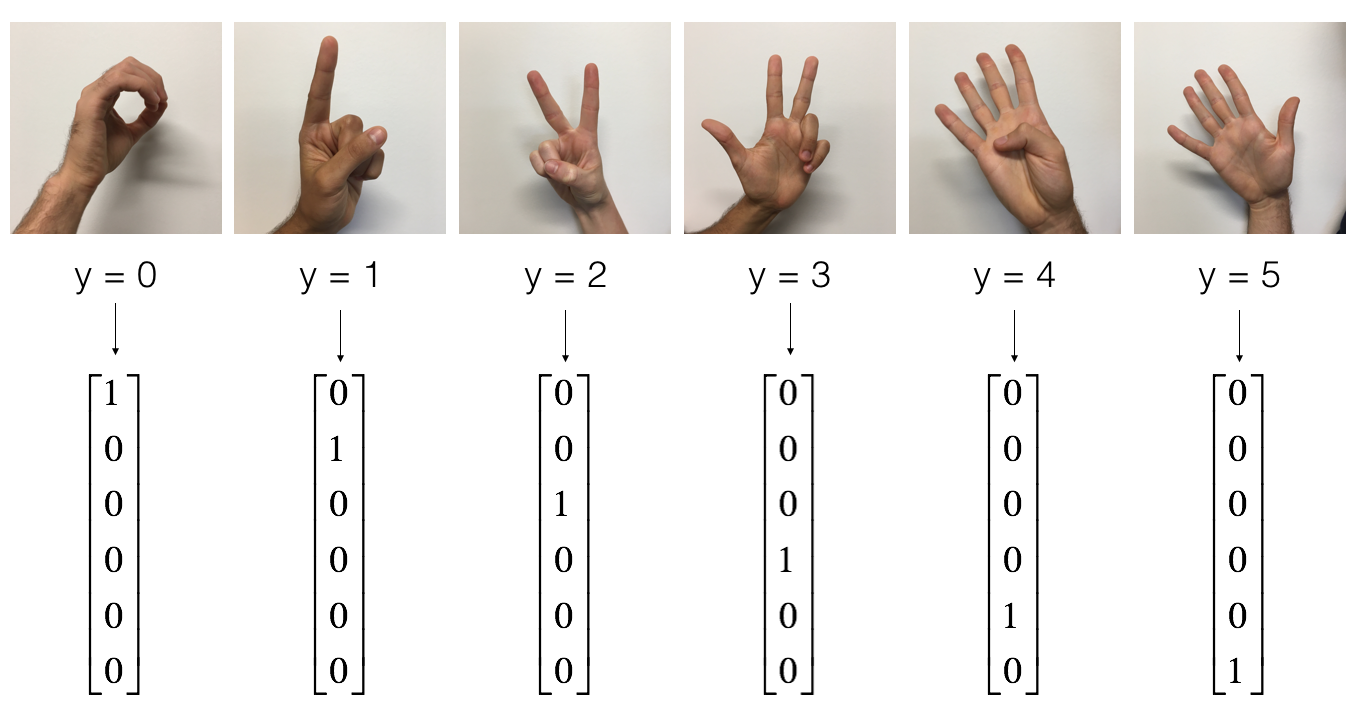

y = 5


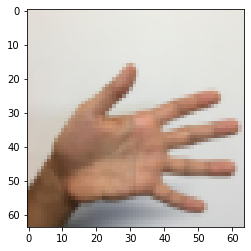

In [10]:

# Example of a picture
index = 0
plt.imshow(train_set_x_orig[index])
print ("y = " + str(np.squeeze(train_set_y_orig[:, index])))

Vous pouvez voir ci-dessous que nos images sont en trois dimensions 64 x 64 x 3.

La première dimension de 64 correspond à la hauteur en pixel de la photo, ici 64 pixels.

La deuxième dimension de 64 correspond à la largeur en pixel de la photo, ici 64 pixels.

La troisième dimension correspond aux intensités de rouge, de vert et de bleu nécessaires pour former la couleur du pixel.

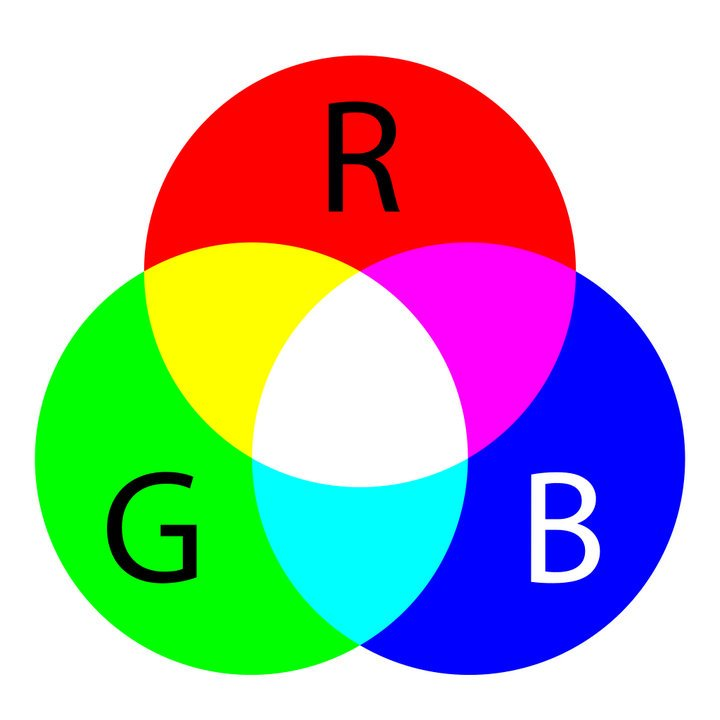

In [23]:
print(train_set_x_orig[0].shape)

(64, 64, 3)


Les valeurs des pixels sont enregistrées dans l’ordinateur ou l’appareil photo numérique sous forme de nombres entiers entre 0 et 255, ce qui fait 256 valeurs possibles pour chaque pixel.

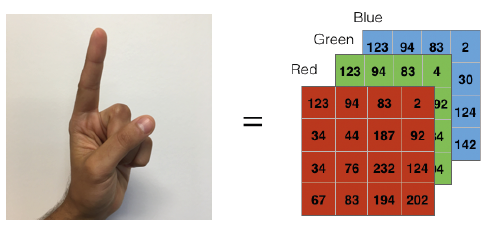

Normalisation

on normalise les donnes afin qu'on puisse reduire la valeur des intensites de l'image afin qu'il soit comprise entre 0 et 1 , en extractent le max et le min de la dataset

In [22]:
print('Valeur minimale de nos images : ',np.min(train_set_x_orig)) #prendre le min de dataset
print('Valeur maximale de nos images : ', np.max(train_set_x_orig)) #prendre le max de dataset

X_train = train_set_x_orig.astype('float32')/255 #le convertire en binaire
X_test = test_set_x_orig.astype('float32')/255

print('Valeur maximum de nos images normalisées : ',np.max(X_train))# prendre le max compris entre 0 et 1
print('Valeur minimum de nos images normalisées : ',np.min(X_train))#prendre le min compris entre 0 et 1

Valeur minimale de nos images :  4
Valeur maximale de nos images :  244
Valeur maximum de nos images normalisées :  0.95686275
Valeur minimum de nos images normalisées :  0.015686275


Dans nos vecteurs "train_set_y_orig" et "test_set_y_orig" nous avons le chiffre correspondant à l'image de la main.
pour chaque vecteur y contient label de chaque image 
c'est-à-dire au lieu d'avoir la valeur 5 on aura un vecteur avec un 1 à la 6ème case.

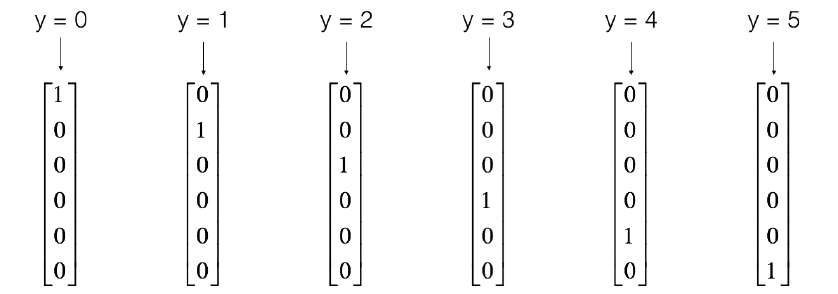

In [12]:
print(train_set_y_orig.reshape(-1))
Y_train = np.eye(6)[train_set_y_orig.reshape(-1)]
Y_test = np.eye(6)[test_set_y_orig.reshape(-1)]
print(Y_train[150, :])
print((train_set_y_orig[:, 150]))

[5 0 2 ... 2 4 5]
[0. 0. 0. 1. 0. 0.]
[3]


Construction de notre modele

In [14]:
model = Sequential()#The model has one input variable, a hidden layer with two neurons, and an output layer with one binary output. Additional layers can be created and added to the model.

Nous allons commencer notre modèle par une couche de convolution. Comme vous pouvez voir ci-dessous, c'est simplement l'application d'un filtre ou (un patche dans chaque pas) sur notre image pour extraire des caractéristiques.

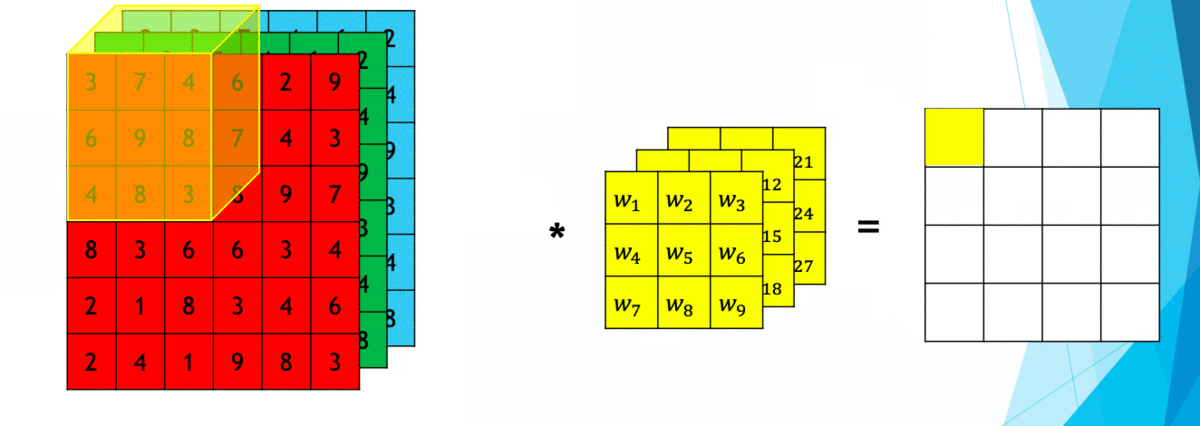

In [15]:
model.add(Conv2D(32, 
                 kernel_size=(3, 3),
                 activation='relu',#La fonction Rectified Linear Unit (ReLU) donne x si x est supérieur à 0, 0 sinon
                 input_shape=(64,64,3)))
model.add(Conv2D(32, 
                 kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(64,64,3)))

Nous allons maintenant ajouter une couche de max-pooling. Comme vous pouvez voir ci-dessous, c'est simplement la sélection de l'intensité la plus grande parmi une sélection de pixels.

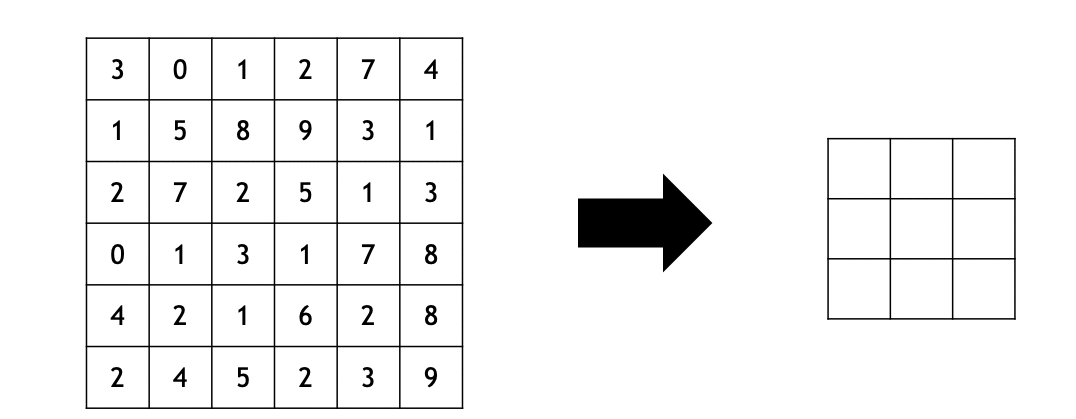

In [17]:
model.add(MaxPooling2D(pool_size=(2,2)))

Maintenant que nous avons extrait des informations de notre image, nous allons transformer ces représentations en vecteur.

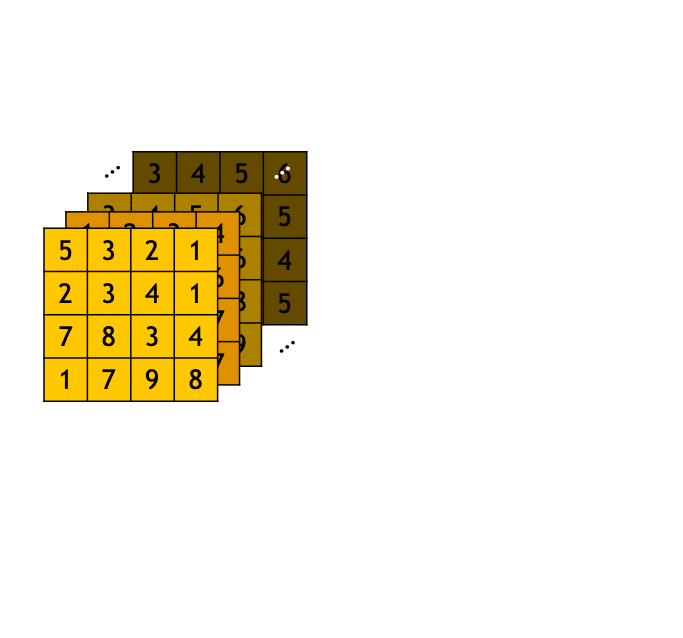

In [18]:
model.add(Flatten())#The flatten() function is used to get a copy of an given array collapsed into one dimension.

Pour finir, nous allons utiliser des couches entièrement connectées pour prédire l'appartenance de nos observations à nos classes.



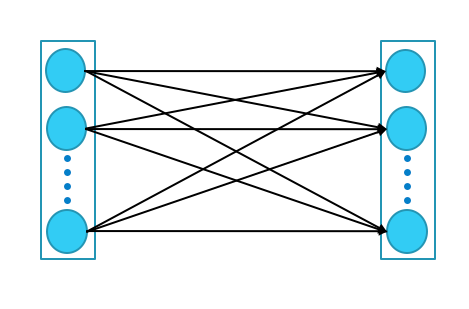

In [19]:
model.add(Dense(6, activation='softmax'))#the softmax activation will output one value for each node in the output layer. The output values will represent (or can be interpreted as) probabilities and the values sum to 1.0.

Notre modèle est assemblé, nous pouvons maintenant le visualiser.



In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 30, 30, 32)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 28800)             0         
                                                                 
 dense (Dense)               (None, 6)                 172806    
                                                                 
Total params: 182,950
Trainable params: 182,950
Non-trainable params: 0
__________________________________________________

Voici une représentation plus visuelle du modèle.

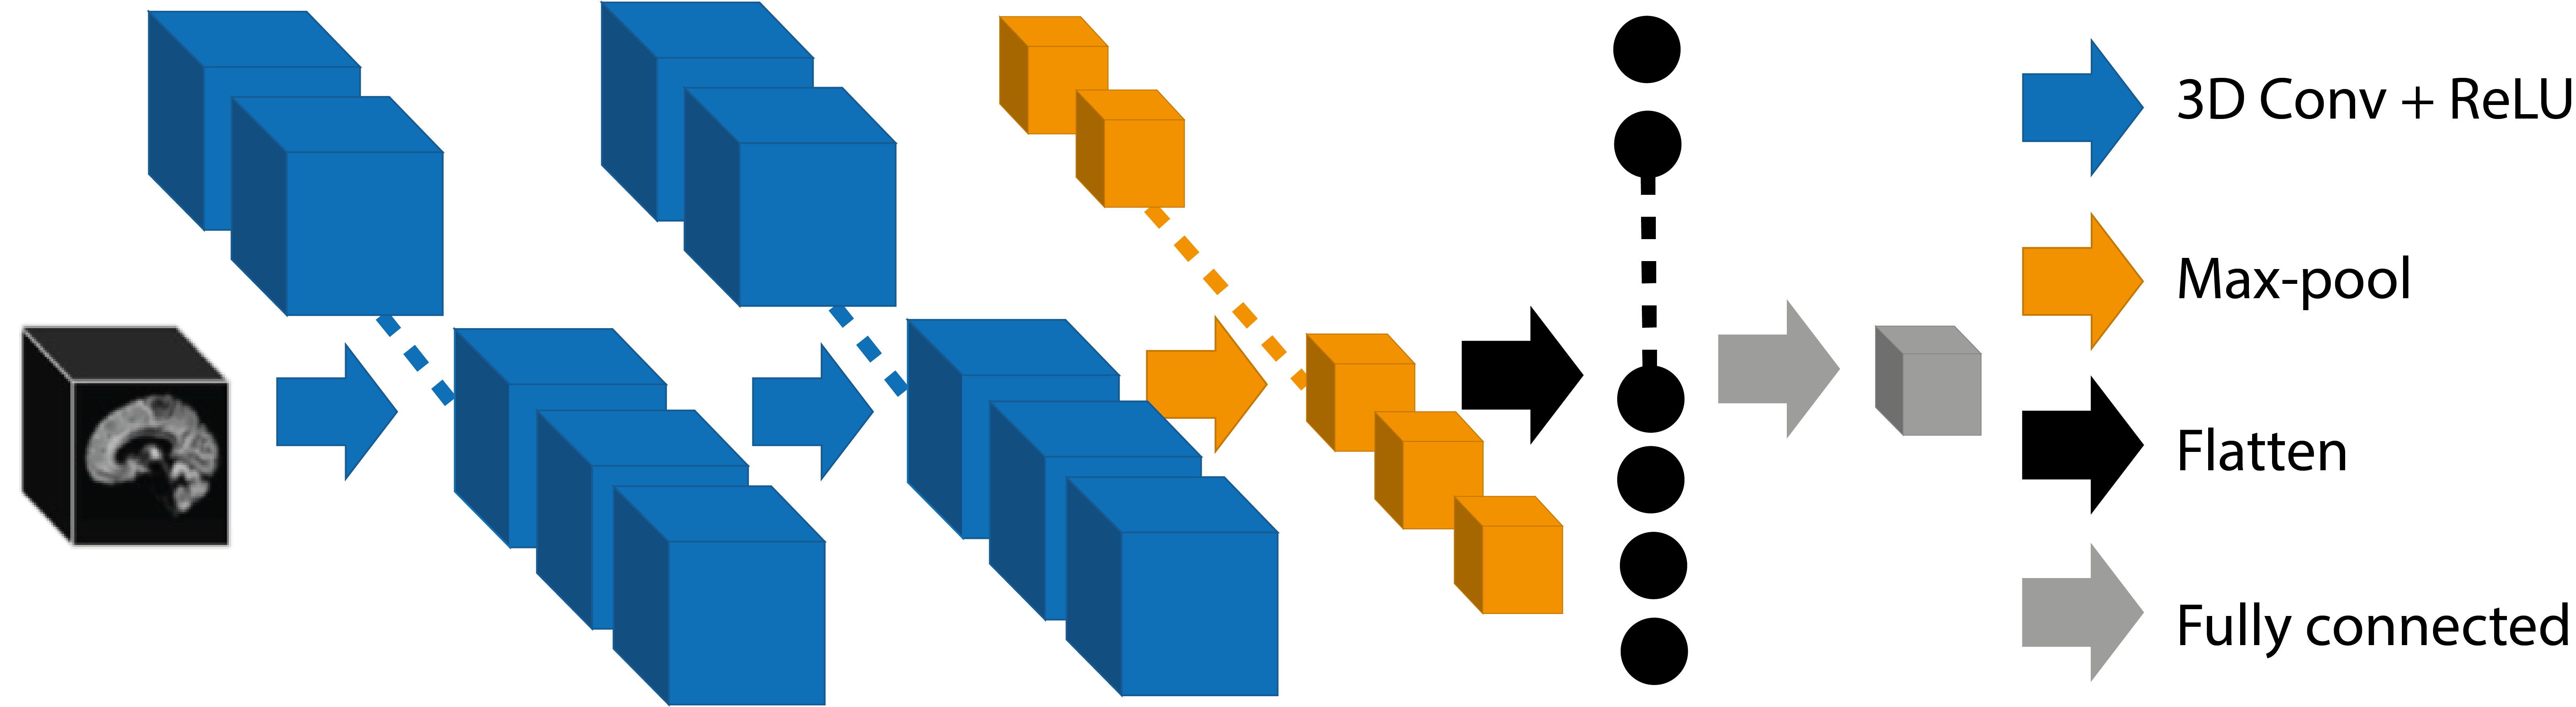

Nous voilà à la dernière étape, l'entraînement de notre modèle.

In [24]:
model.compile(loss="categorical_crossentropy", optimizer=SGD(lr=0.01), metrics=["accuracy"])#loss : pour verifier la fonction cout , omptimiser le model , metric pour verufier la performance de notre model
model.fit(X_train, Y_train,
          epochs = 5,
          validation_data=(X_test, Y_test))

Epoch 1/10
20/34 [================>.............] - ETA: 5s - loss: 1.6635 - accuracy: 0.3203

KeyboardInterrupt: ignored

Pour finir ce notebook, nous allons sauvegarder les paramètres de notre modèle si nous voulons l'utiliser à nouveau plus tard.



In [1]:
model.save_weights('CNN model')

NameError: ignored